In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/falldetec-yolov11/README.dataset.txt
/kaggle/input/falldetec-yolov11/README.roboflow.txt
/kaggle/input/falldetec-yolov11/data.yaml
/kaggle/input/falldetec-yolov11/valid/labels/Screenshot-2022-08-09-105244_jpg.rf.421cf25fdbd1b0c8b3c1c9d18b55357a.txt
/kaggle/input/falldetec-yolov11/valid/labels/Screenshot-2022-08-09-104819_jpg.rf.259ea1babcc11c7eedc24e168de5a276.txt
/kaggle/input/falldetec-yolov11/valid/labels/people-7613-_jpg.rf.124d5433ee9d49354879351fc176ba52.txt
/kaggle/input/falldetec-yolov11/valid/labels/00076_png_jpg.rf.97631b132f7a1a6e03dd1c5cc9e005f0.txt
/kaggle/input/falldetec-yolov11/valid/labels/screen-22-34-04-04-11-2023-_png.rf.11893996aa50ba8543981e81541d64c8.txt
/kaggle/input/falldetec-yolov11/valid/labels/000000006763_jpg.rf.819ab1e65d88f9d02ffe15b6d36e1033.txt
/kaggle/input/falldetec-yolov11/valid/labels/Screenshot-2022-08-09-104752_jpg.rf.05019a497d8e27dd0320480b47491df6.txt
/kaggle/input/falldetec-yolov11/valid/labels/people-3640-_jpg.rf.e91eacc491981ff3

## Install & Import All Required Libraries

In [2]:

!pip install -U ultralytics opencv-python matplotlib seaborn tqdm pyyaml

import os
import glob
import random
import yaml
from pathlib import Path
from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

print(" All libraries installed and imported successfully")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 19.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 71.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 67.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.3 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211

## Verify Dataset & data.yaml

In [3]:
DATASET_PATH = "/kaggle/input/falldetec-yolov11"

with open(f"{DATASET_PATH}/data.yaml", "r") as f:
    data_cfg = yaml.safe_load(f)

print("📄 data.yaml content:")
print(data_cfg)

print("\n Dataset Summary:")
for split in ["train", "valid", "test"]:
    img_dir = f"{DATASET_PATH}/{split}/images"
    lbl_dir = f"{DATASET_PATH}/{split}/labels"

    num_imgs = len(glob.glob(img_dir + "/*"))
    num_lbls = len(glob.glob(lbl_dir + "/*"))

    print(f"{split.upper():5s} | Images: {num_imgs:5d} | Labels: {num_lbls:5d}")


📄 data.yaml content:
{'train': '../train/images', 'val': '../valid/images', 'test': '../test/images', 'nc': 2, 'names': ['fall', 'no-fall'], 'roboflow': {'workspace': 'falldetection-e1wuj', 'project': 'fall-detection-qyulz', 'version': 7, 'license': 'CC BY 4.0', 'url': 'https://universe.roboflow.com/falldetection-e1wuj/fall-detection-qyulz/dataset/7'}}

 Dataset Summary:
TRAIN | Images: 15651 | Labels: 15651
VALID | Images:  1138 | Labels:  1138
TEST  | Images:  1184 | Labels:  1184


## Visualize Random Samples 

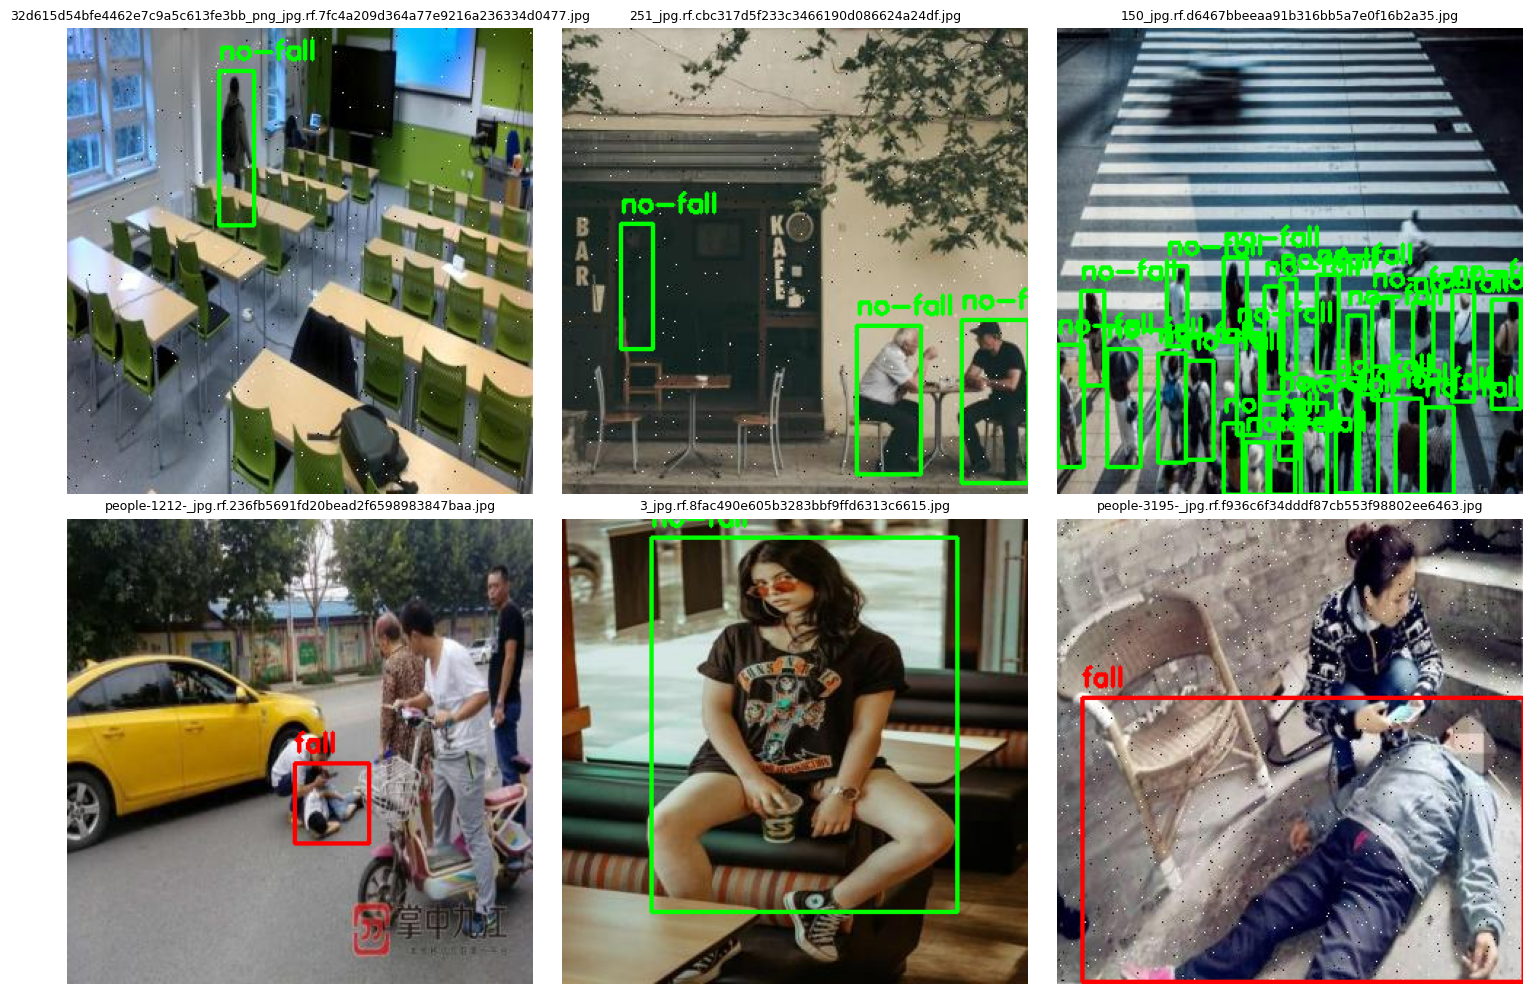

In [5]:
def visualize_fall_and_no_fall(split="train", total_images=6):
    img_dir = f"{DATASET_PATH}/{split}/images"
    lbl_dir = f"{DATASET_PATH}/{split}/labels"

    images = os.listdir(img_dir)
    random.shuffle(images)

    selected = []

    for img_name in images:
        if len(selected) >= total_images:
            break

        lbl_path = os.path.join(lbl_dir, img_name.replace(".jpg", ".txt"))
        if not os.path.exists(lbl_path):
            continue

        with open(lbl_path) as f:
            labels = f.readlines()

        classes = [int(line.split()[0]) for line in labels]

        # نختار صور فيها fall أو no-fall
        if 0 in classes or 1 in classes:
            selected.append(img_name)

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    for ax, img_name in zip(axes, selected):
        img_path = os.path.join(img_dir, img_name)
        lbl_path = os.path.join(lbl_dir, img_name.replace(".jpg", ".txt"))

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w, _ = img.shape

        with open(lbl_path) as f:
            for line in f:
                cls, xc, yc, bw, bh = map(float, line.split())
                x1 = int((xc - bw/2) * w)
                y1 = int((yc - bh/2) * h)
                x2 = int((xc + bw/2) * w)
                y2 = int((yc + bh/2) * h)

                if int(cls) == 0:
                    color = (255, 0, 0)
                    label = "fall"
                else:
                    color = (0, 255, 0)
                    label = "no-fall"

                cv2.rectangle(img, (x1,y1), (x2,y2), color, 2)
                cv2.putText(img, label, (x1, y1-8),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

        ax.imshow(img)
        ax.set_title(img_name, fontsize=9)
        ax.axis("off")

    plt.tight_layout()
    plt.show()


visualize_fall_and_no_fall(split="train", total_images=6)


## Train YOLO v11s

In [3]:
!pip install -U ultralytics
from ultralytics import YOLO

print("✅ Ultralytics installed and YOLO imported")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 22.0 MB/s eta 0:00:00a 0:00:01
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
✅ Ultralytics installed and YOLO imported


In [6]:
DATASET_PATH = "/kaggle/input/falldetec-yolov11"

model = YOLO("yolo11s.pt")

model.train(
    data=f"{DATASET_PATH}/data.yaml",
    epochs=50,
    imgsz=640,
    batch=32,
    optimizer="AdamW",
    lr0=0.001,
    patience=20,
    device=0   # اشتغل فقط إذا GPU مفعّل
)


Ultralytics 8.3.252 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/input/falldetec-yolov11/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train3, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=20, perspective=0.0, plots=

KeyboardInterrupt: 

In [10]:
!ls runs/detect
!ls runs/detect/train3/weights
import os
os.path.exists("runs/detect/train3/weights/best.pt")


predict  predict2  train  train2  train3
best.pt  last.pt


True

## Inference & Demo Preparation

### Inference

In [22]:
from ultralytics import YOLO

model = YOLO("runs/detect/train3/weights/best.pt")

_ = model.predict(
    source="/kaggle/working/demo_images",
    conf=0.5,
    save=True,
    save_txt=True,  
    verbose=False
)


Results saved to /kaggle/working/runs/detect/predict6
9 labels saved to /kaggle/working/runs/detect/predict6/labels


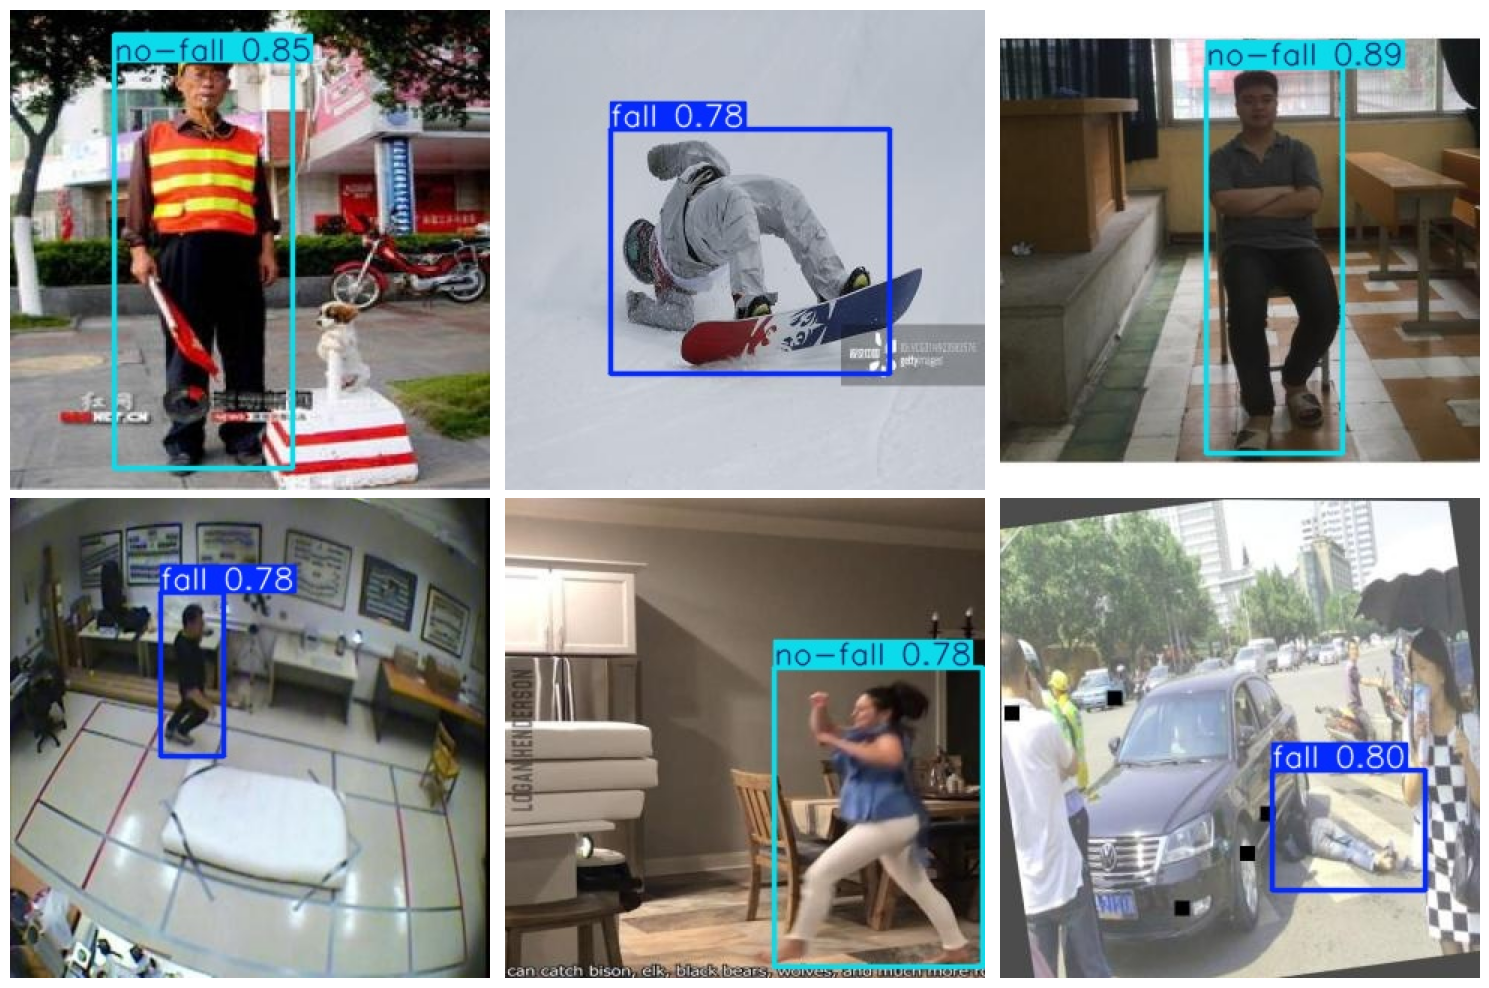

In [25]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import time

PRED_PATH = "/kaggle/working/runs/detect/predict6"
LABEL_PATH = os.path.join(PRED_PATH, "labels")

# force real randomness every run
np.random.seed(int(time.time()))

fall_imgs = []
nofall_imgs = []

for lbl in os.listdir(LABEL_PATH):
    lbl_path = os.path.join(LABEL_PATH, lbl)
    with open(lbl_path) as f:
        classes = [int(line.split()[0]) for line in f.readlines()]

    img_name = lbl.replace(".txt", ".jpg")
    img_path = os.path.join(PRED_PATH, img_name)

    if not os.path.exists(img_path):
        continue

    if 0 in classes:
        fall_imgs.append(img_name)
    elif 1 in classes:
        nofall_imgs.append(img_name)

# pick 3 from each
selected_fall = np.random.choice(fall_imgs, 3, replace=False)
selected_nofall = np.random.choice(nofall_imgs, 3, replace=False)

selected = list(selected_fall) + list(selected_nofall)
np.random.shuffle(selected)

# plot 3x2
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for ax, img_name in zip(axes, selected):
    img = cv2.imread(os.path.join(PRED_PATH, img_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.axis("off")

plt.tight_layout()
plt.show()


## Confusion Matrix

In [27]:
import matplotlib.pyplot as plt
from PIL import Image

cm_path = "runs/detect/train3/confusion_matrix.png"

img = Image.open(cm_path)
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.axis("off")
plt.title("Confusion Matrix")
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'runs/detect/train3/results.png'

In [30]:
from ultralytics import YOLO

model = YOLO("runs/detect/train3/weights/best.pt")

metrics = model.val(
    data="/kaggle/input/falldetec-yolov11/data.yaml",
    split="test",
    save=True,
    verbose=False
)


Ultralytics 8.3.252 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,413,574 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.2±0.5 ms, read: 29.9±10.6 MB/s, size: 16.0 KB)
val: Scanning /kaggle/input/falldetec-yolov11/test/labels... 1184 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1184/1184 382.9it/s 3.1s<0.0s
WARNING ⚠️ val: Cache directory /kaggle/input/falldetec-yolov11/test is not writable, cache not saved.
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 2, len(boxes) = 1500. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 74/74 4.5it/s 16.5s0.2s
                   all       1184       1500      0.752      0.722      0.739      0.483
Speed: 0.

# Evaluation

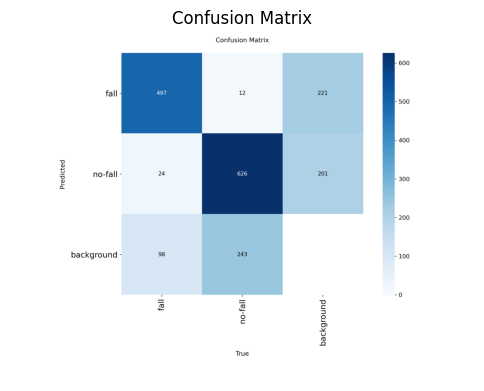

In [31]:
import matplotlib.pyplot as plt
from PIL import Image

cm_path = "runs/detect/val/confusion_matrix.png"

img = Image.open(cm_path)
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.axis("off")
plt.title("Confusion Matrix")
plt.show()


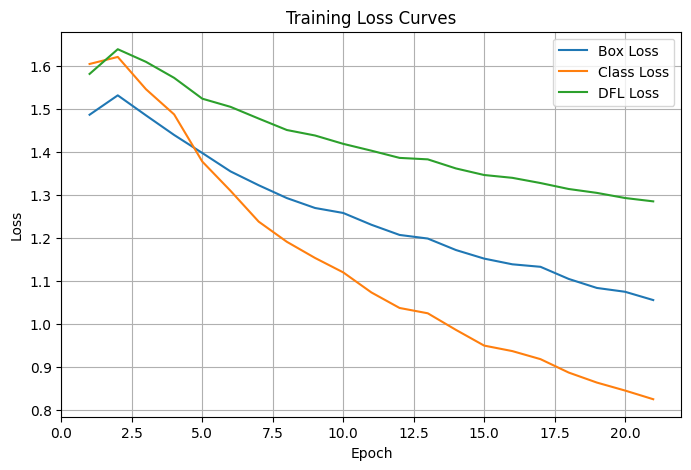

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(df["epoch"], df["train/box_loss"], label="Box Loss")
plt.plot(df["epoch"], df["train/cls_loss"], label="Class Loss")
plt.plot(df["epoch"], df["train/dfl_loss"], label="DFL Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curves")
plt.legend()
plt.grid(True)
plt.show()


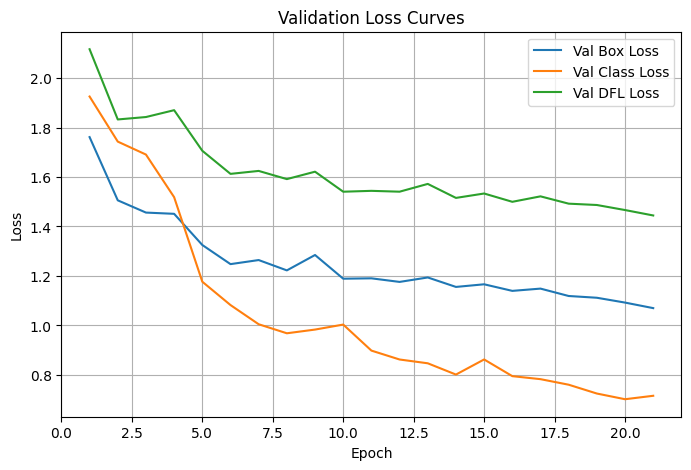

In [38]:
plt.figure(figsize=(8,5))
plt.plot(df["epoch"], df["val/box_loss"], label="Val Box Loss")
plt.plot(df["epoch"], df["val/cls_loss"], label="Val Class Loss")
plt.plot(df["epoch"], df["val/dfl_loss"], label="Val DFL Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Validation Loss Curves")
plt.legend()
plt.grid(True)
plt.show()


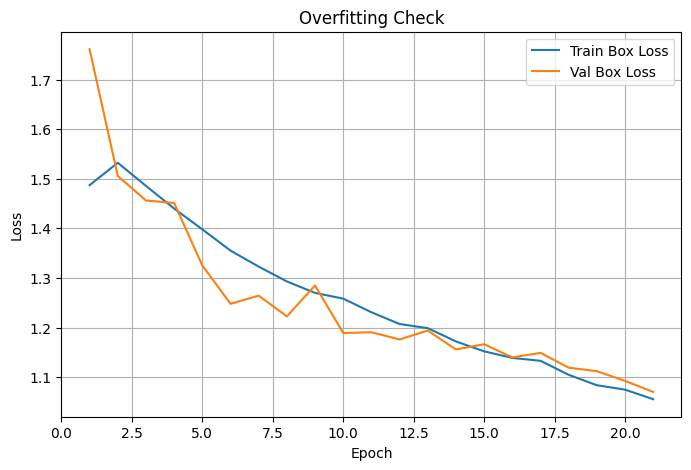

In [44]:
plt.figure(figsize=(8,5))
plt.plot(df["epoch"], df["train/box_loss"], label="Train Box Loss")
plt.plot(df["epoch"], df["val/box_loss"], label="Val Box Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Overfitting Check")
plt.legend()
plt.grid(True)
plt.show()


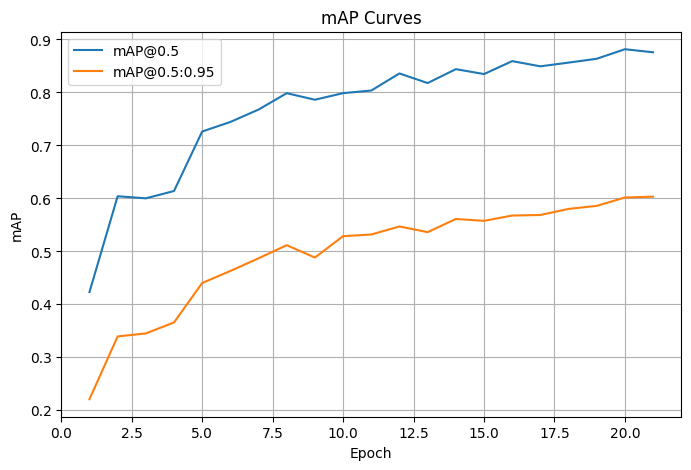

In [39]:
plt.figure(figsize=(8,5))
plt.plot(df["epoch"], df["metrics/mAP50(B)"], label="mAP@0.5")
plt.plot(df["epoch"], df["metrics/mAP50-95(B)"], label="mAP@0.5:0.95")

plt.xlabel("Epoch")
plt.ylabel("mAP")
plt.title("mAP Curves")
plt.legend()
plt.grid(True)
plt.show()


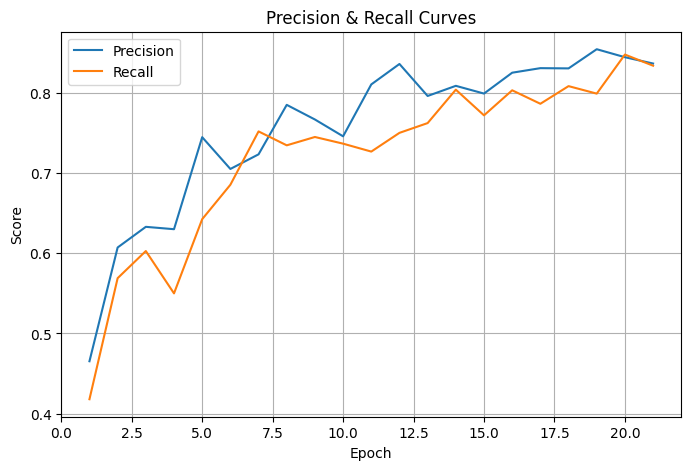

In [40]:
plt.figure(figsize=(8,5))
plt.plot(df["epoch"], df["metrics/precision(B)"], label="Precision")
plt.plot(df["epoch"], df["metrics/recall(B)"], label="Recall")

plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Precision & Recall Curves")
plt.legend()
plt.grid(True)
plt.show()


### Summary Metrics Table

In [41]:
final_metrics = {
    "mAP@0.5": df["metrics/mAP50(B)"].iloc[-1],
    "mAP@0.5:0.95": df["metrics/mAP50-95(B)"].iloc[-1],
    "Precision": df["metrics/precision(B)"].iloc[-1],
    "Recall": df["metrics/recall(B)"].iloc[-1],
}

summary_df = pd.DataFrame(final_metrics, index=["Final"])
summary_df


mAP@0.5  mAP@0.5:0.95  Precision  Recall
Final  0.87569        0.6033     0.8365  0.8338

### Best Epoch Detection

In [42]:
best_epoch = df["metrics/mAP50(B)"].idxmax()
best_epoch, df.loc[best_epoch, "metrics/mAP50(B)"]


(19, np.float64(0.88148))